In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [2]:
states_path = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip"

states_gdf = gpd.read_file(states_path)

In [6]:
# Get netcdf file
data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'

# Open up the data
with xr.open_dataset(data_path_monthly) as file_nc:
    monthly_forecast_temp_xr = file_nc

# xarray object
monthly_forecast_temp_xr

<xarray.Dataset>
Dimensions:          (crs: 1, lat: 585, lon: 1386, time: 1128)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs              (crs) int32 1
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [7]:
# Would this be better if it only returned 4 values?? probably so
# Helper Function to extract AOI
def get_aoi(shp, world=True):
    """Takes a geopandas object and converts it to a lat/ lon
    extent """

    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    # Handle the 0-360 lon values
    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

In [8]:
# Create AOI Subset
cali_or_wash_nev = states_gdf[states_gdf.name.isin(
    ["California", "Oregon", "Washington", "Nevada"])]
west_bounds = get_aoi(cali_or_wash_nev)

# Create the mask
west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)


# Slice by time & aoi location
start_date = "2059-12-15"
end_date = "2099-12-15"

west_temp = monthly_forecast_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date),
    lon=slice(west_bounds["lon"][0], west_bounds["lon"][1]),
    lat=slice(west_bounds["lat"][0], west_bounds["lat"][1]))

# Apply the mask
west_temp_masked = west_temp.where(west_mask)
west_temp_masked
# Resample the data by season across all years
#west_season_mean_all_years = west_temp_masked.groupby('region').resample(time='QS-DEC', keep_attrs=True).mean()
# cali_seasonal_mean = cali_season_mean_all_years.groupby('time').mean(["lat", "lon"])
# cali_seasonal_mean

<xarray.DataArray 'air_temperature' (time: 481, lat: 395, lon: 256, region: 4)>
array([[[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 48.85 48.9 48.94 48.98
  * lon      (lon) float64 235.3 235.4 235.4 235.4 ... 245.8 245.9 245.9 245.9
  * time     (time) object 2059-12-15 00:00:00 ... 2099-12-15 00:00:00
  * region   (region) int32 53 82 86 96
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [9]:
# This produces a raster for each season over time across regions
west_coast_mean_temp_raster = west_temp_masked.resample(
    time='QS-DEC', keep_attrs=True).mean()
west_coast_mean_temp_raster.shape

C:\Users\34639\anaconda3\envs\geo_env\lib\site-packages\xarray\core\common.py:1127: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


(161, 395, 256, 4)

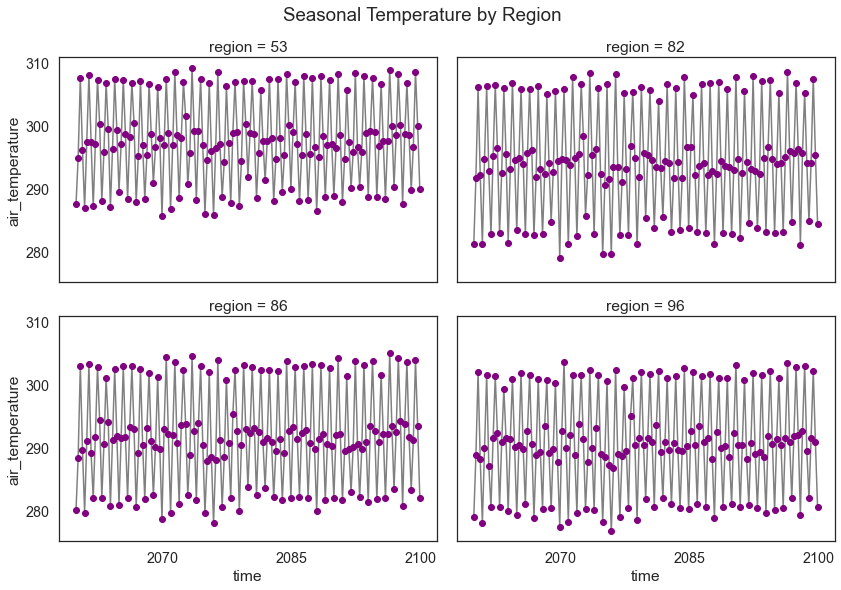

In [10]:
# This produces a regional summary
regional_summary = west_coast_mean_temp_raster.groupby('time').mean([
    "lat", "lon"])
regional_summary.plot(col="region",
                      marker="o",
                      color="grey",
                      markerfacecolor="purple",
                      markeredgecolor="purple",
                      col_wrap=2,
                      figsize=(12, 8))

plt.suptitle("Seasonal Temperature by Region", y=1.03)
plt.show()

In [11]:
# The data can then be easily converted to a dataframe
regional_summary.to_dataframe()

air_temperature
time                region                 
2059-12-01 00:00:00 53           287.588531
                    82           281.238739
                    86           280.193787
                    96           279.038940
2060-03-01 00:00:00 53           294.914886
...                                     ...
2099-09-01 00:00:00 96           290.840363
2099-12-01 00:00:00 53           289.929504
                    82           284.486908
                    86           282.051971
                    96           280.577484

[644 rows x 1 columns]